In [34]:
# install.packages(c("tidyverse", "ggplot2", "DataExplorer", "corrplot", "scales", "gridExtra", "caret", "pROC", "car", "MASS", "caTools"))

library(tidyverse)
library(caret)
library(pROC)
library(car)
library(MASS)
library(ggplot2)
library(scales)
library(DataExplorer)
library(corrplot)
library(caTools)
library(xgboost)
library(readr)
library(ggpubr)

In [35]:
# load training dataset and test dataset
train_data <- read.csv("train.csv")
test_data <- read.csv("test.csv")

head(train_data)
head(test_data)


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
,<int>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<int>,<int>
1,0,37,35000,RENT,0,EDUCATION,B,6000,11.49,0.17,N,14,0
2,1,22,56000,OWN,6,MEDICAL,C,4000,13.35,0.07,N,2,0
3,2,29,28800,OWN,8,PERSONAL,A,6000,8.90,0.21,N,10,0
4,3,30,70000,RENT,14,VENTURE,B,12000,11.11,0.17,N,5,0
5,4,22,60000,RENT,2,MEDICAL,A,6000,6.92,0.10,N,3,0
6,5,27,45000,RENT,2,VENTURE,A,9000,8.94,0.20,N,5,0


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
,<int>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<int>
1,58645,23,69000,RENT,3,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
2,58646,26,96000,MORTGAGE,6,PERSONAL,C,10000,12.68,0.10,Y,4
3,58647,26,30000,RENT,5,VENTURE,E,4000,17.19,0.13,Y,2
4,58648,33,50000,RENT,4,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
5,58649,26,102000,MORTGAGE,8,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
6,58650,23,66000,RENT,5,EDUCATION,D,22000,14.09,0.33,N,2


[1] "Missing Values per Column:"
                        id                 person_age 
                         0                          0 
             person_income      person_home_ownership 
                         0                          0 
         person_emp_length                loan_intent 
                         0                          0 
                loan_grade                  loan_amnt 
                         0                          0 
             loan_int_rate        loan_percent_income 
                         0                          0 
 cb_person_default_on_file cb_person_cred_hist_length 
                         0                          0 
               loan_status 
                         0 


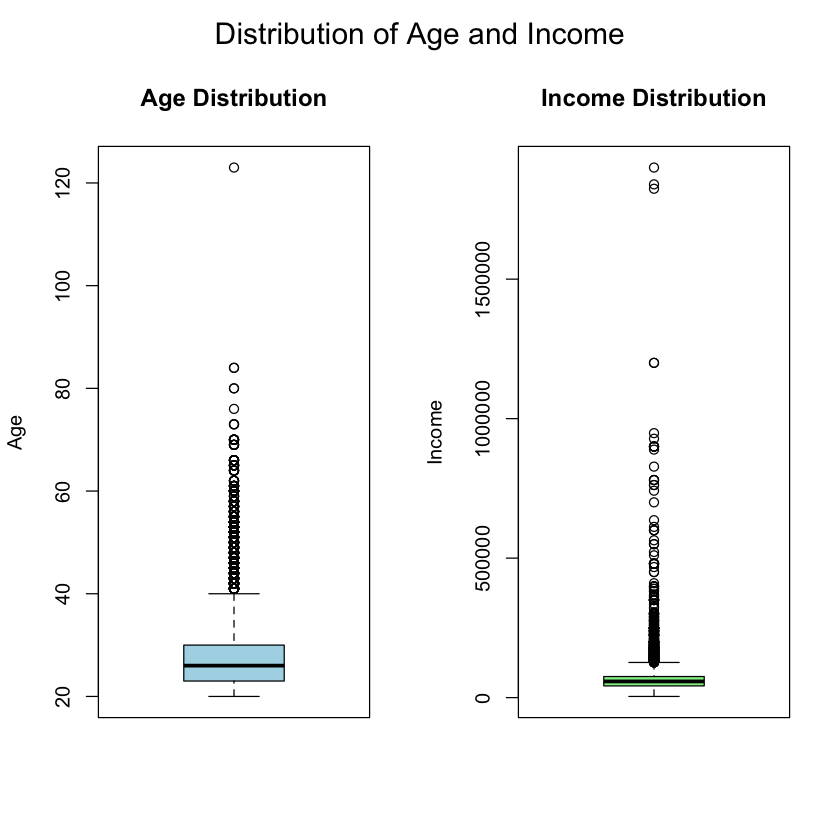

In [36]:
# Data Cleaning, check for missing values
missing_values <- colSums(is.na(train_data))
print("Missing Values per Column:")
print(missing_values)

# There is no missing values in the dataset

# Process the outliers
par(mfrow=c(1,2), oma=c(0,0,2,0))  
boxplot(train_data$person_age, 
        main = "Age Distribution",
        ylab = "Age",
        bg = "white", 
        col = "lightblue")
boxplot(train_data$person_income, 
        main = "Income Distribution",
        ylab = "Income",
        bg = "white", 
        col = "lightgreen")
mtext("Distribution of Age and Income", outer = TRUE, cex = 1.5)


In [37]:
calculate_and_print_outliers <- function(data, variable_name, allow_negative = FALSE) {
    Q1 <- quantile(data, 0.25)
    Q3 <- quantile(data, 0.75)
    IQR <- Q3 - Q1
    
    lower_bound <- Q1 - 1.5 * IQR
    upper_bound <- Q3 + 1.5 * IQR
    
    if (!allow_negative) {
        lower_bound <- max(0, lower_bound)
    }
    
    outliers <- data[data < lower_bound | data > upper_bound]
    outlier_count <- length(outliers)
    total_count <- length(data)
    outlier_percentage <- (outlier_count / total_count) * 100
    
    cat("\n", variable_name, "Outliers:\n", sep = "")
    cat("Count:", outlier_count, "\n")
    cat("Percentage:", round(outlier_percentage, 2), "%\n")
    cat("Boundaries: [", round(lower_bound, 2), ",", round(upper_bound, 2), "]\n")
}

calculate_and_print_outliers(train_data$person_age, "Age", allow_negative = FALSE)
calculate_and_print_outliers(train_data$person_income, "Income", allow_negative = FALSE)


AgeOutliers:
Count: 2446 
Percentage: 4.17 %
Boundaries: [ 12.5 , 40.5 ]

IncomeOutliers:
Count: 2411 
Percentage: 4.11 %
Boundaries: [ 0 , 126000 ]


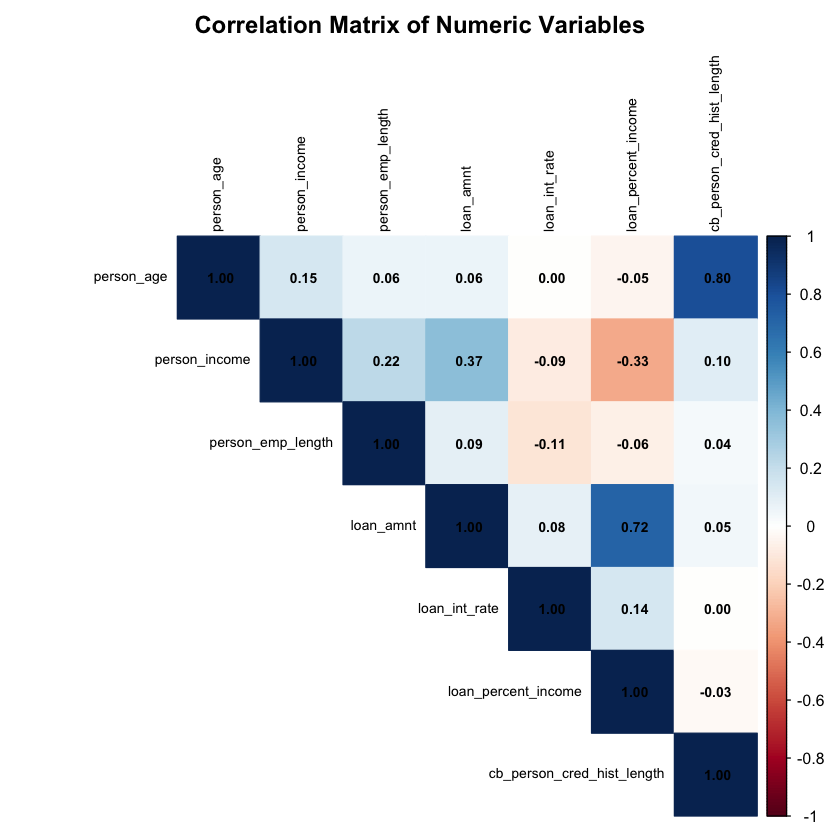

In [38]:
# Create correlation matrix
numeric_cols <- sapply(train_data, is.numeric)
correlation_matrix <- cor(train_data[, numeric_cols & !names(train_data) %in% c("id", "loan_status")],method = "spearman")

corrplot(correlation_matrix, 
         method = "color",
         type = "upper",
         addCoef.col = "black",
         number.cex = 0.7,
         tl.cex = 0.7,
         tl.col = "black",  
         title = "Correlation Matrix of Numeric Variables",
         mar = c(0,0,2,0),
         bg = "white")  

Implement a logistic regression model to predict the loan status for each candidate. 

In [39]:
test_data$person_home_ownership <- as.factor(test_data$person_home_ownership)
test_data$loan_intent <- as.factor(test_data$loan_intent)
test_data$loan_grade <- as.factor(test_data$loan_grade)
test_data$cb_person_default_on_file <- as.factor(test_data$cb_person_default_on_file)

In [40]:
set.seed(314)
split <- sample.split(train_data$loan_status, SplitRatio = 0.8)
train_set <- subset(train_data, split == TRUE)
val_set <- subset(train_data, split == FALSE)

nrow(train_set)
nrow(val_set)

[1] 46916

[1] 11729

[1] "VIF values:"
                                GVIF Df GVIF^(1/(2*Df))
id                          1.001081  1        1.000540
person_age                  4.347858  1        2.085152
person_income               4.261487  1        2.064337
person_home_ownership       1.188947  3        1.029265
person_emp_length           1.088614  1        1.043367
loan_intent                 1.110476  5        1.010534
loan_grade                 13.990010  6        1.245905
loan_amnt                   6.791888  1        2.606125
loan_int_rate              10.651304  1        3.263634
loan_percent_income         5.696376  1        2.386708
cb_person_default_on_file   1.535637  1        1.239208
cb_person_cred_hist_length  4.299601  1        2.073548


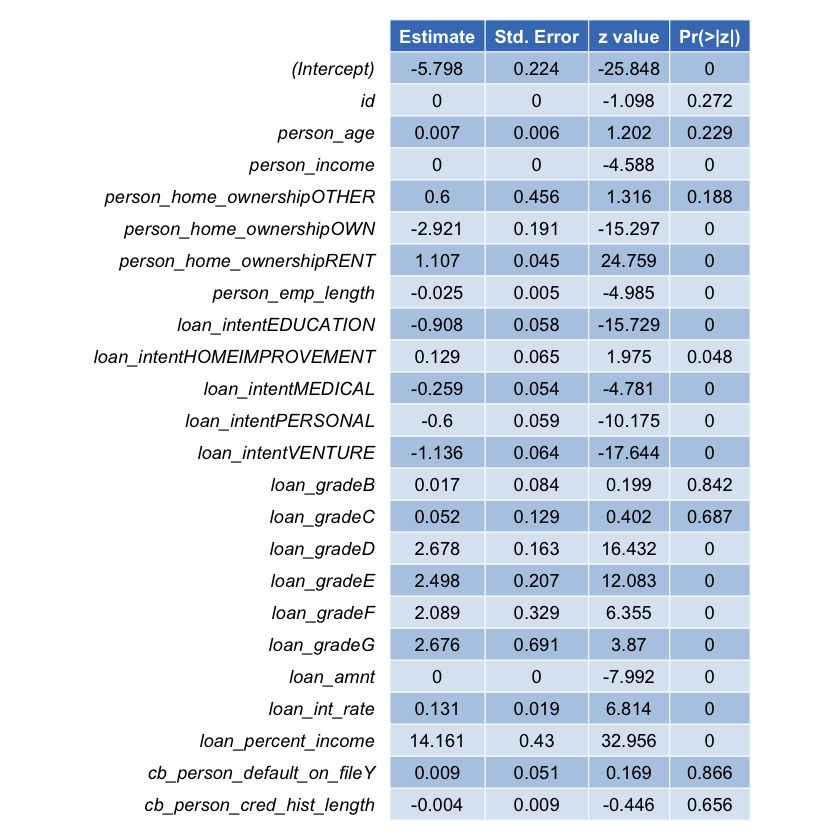

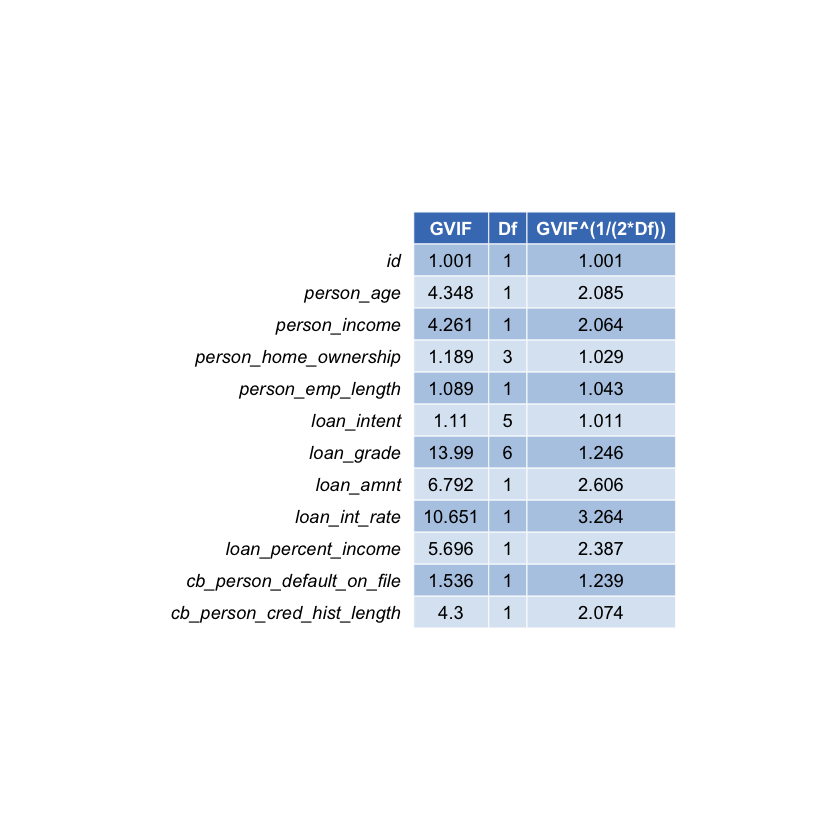

In [41]:
logistic_model <- glm(loan_status ~ ., data = train_set, family = "binomial")

vif_values <- vif(logistic_model)
print("VIF values:")
print(vif_values)

library(ggpubr)
ggtexttable(as.data.frame(round(summary(logistic_model)$coefficients, 3)), 
            rows = rownames(summary(logistic_model)$coefficients), 
            theme = ttheme("mBlue"))

ggtexttable(as.data.frame(round(vif_values, 3)), 
            theme = ttheme("mBlue"))

In [42]:
table(train_data$person_home_ownership, train_data$loan_status) %>%
  prop.table(margin = 1)

# Calculate how many people own a house
house_owners <- sum(train_data$person_home_ownership == "OWN")
print(paste("Number of people who own a house:", house_owners))

          
                    0          1
  MORTGAGE 0.94025943 0.05974057
  OTHER    0.83146067 0.16853933
  OWN      0.98629700 0.01370300
  RENT     0.77744002 0.22255998

[1] "Number of people who own a house: 3138"


In [43]:
val_predictions <- predict(logistic_model, newdata = val_set, type = "response")
val_pred_class <- ifelse(val_predictions > 0.5, 1, 0)

     Metric Value
1  Accuracy 0.912
2 Precision 0.779
3    Recall 0.535
4  F1 Score 0.634


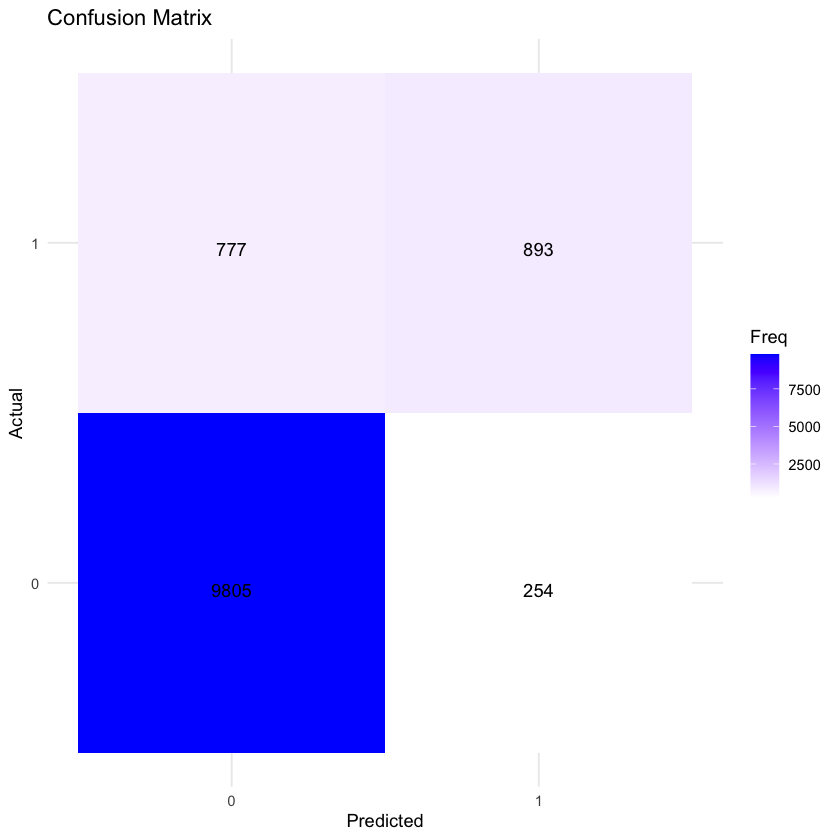

In [48]:

conf_matrix <- table(Predicted = val_pred_class, Actual = val_set$loan_status)

accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
precision <- conf_matrix[2, 2] / sum(conf_matrix[2, ])
recall <- conf_matrix[2, 2] / sum(conf_matrix[, 2])
f1_score <- 2 * (precision * recall) / (precision + recall)

metrics_df <- data.frame(
  Metric = c("Accuracy", "Precision", "Recall", "F1 Score"),
  Value = round(c(accuracy, precision, recall, f1_score), 3)
)

print(metrics_df)

conf_matrix_df <- as.data.frame(as.table(conf_matrix))

conf_matrix_plot <- ggplot(conf_matrix_df, aes(x = Predicted, y = Actual, fill = Freq)) +
  geom_tile() +
  geom_text(aes(label = Freq), vjust = 1) +
  scale_fill_gradient(low = "white", high = "blue") +
  theme_minimal() +
  labs(title = "Confusion Matrix", x = "Predicted", y = "Actual")

print(conf_matrix_plot)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



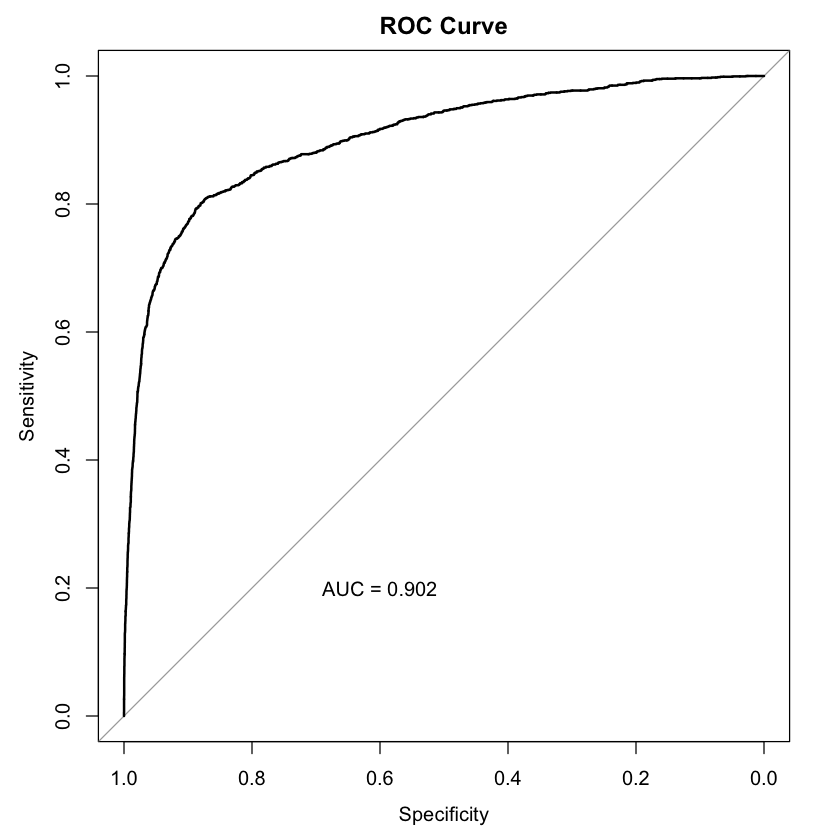

In [49]:
roc_obj <- roc(val_set$loan_status, val_predictions)
auc_value <- auc(roc_obj)

plot(roc_obj, main = "ROC Curve")
text(0.6, 0.2, paste("AUC =", round(auc_value, 3)))

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



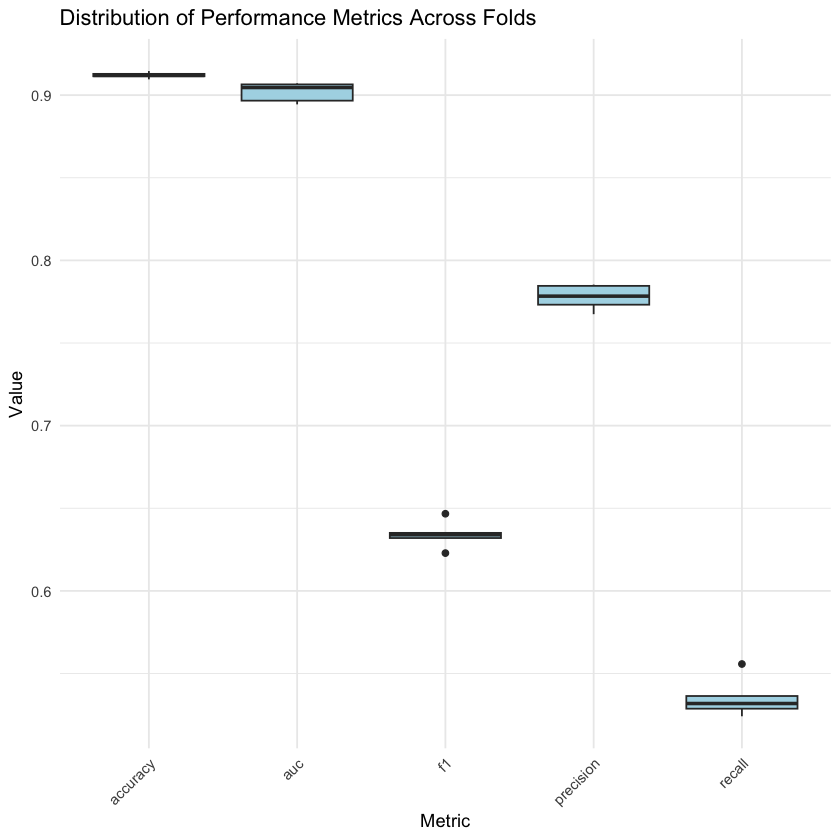

In [50]:
# k-fold cross validation
set.seed(3112)

k <- 5  
folds <- createFolds(train_data$loan_status, k = k, list = TRUE)

metrics <- data.frame(
    fold = 1:k,
    accuracy = numeric(k),
    precision = numeric(k),
    recall = numeric(k),
    f1 = numeric(k),
    auc = numeric(k)
)

for(i in 1:k) {
    
    val_indices <- folds[[i]]
    fold_train <- train_data[-val_indices, ]
    fold_val <- train_data[val_indices, ]
    
    model <- glm(loan_status ~ ., data = fold_train, family = "binomial")
    
    predictions <- predict(model, newdata = fold_val, type = "response")
    pred_class <- ifelse(predictions > 0.5, 1, 0)
    
    conf_matrix <- table(Predicted = pred_class, Actual = fold_val$loan_status)
    metrics$accuracy[i] <- sum(diag(conf_matrix)) / sum(conf_matrix)
    metrics$precision[i] <- conf_matrix[2,2] / sum(conf_matrix[2,])
    metrics$recall[i] <- conf_matrix[2,2] / sum(conf_matrix[,2])
    metrics$f1[i] <- 2 * (metrics$precision[i] * metrics$recall[i]) / 
                        (metrics$precision[i] + metrics$recall[i])
    
    roc_obj <- roc(fold_val$loan_status, predictions)
    metrics$auc[i] <- auc(roc_obj)
}


metrics_long <- tidyr::gather(metrics[,-1], key = "metric", value = "value")

ggplot(metrics_long, aes(x = metric, y = value)) +
    geom_boxplot(fill = "lightblue") +
    theme_minimal() +
    labs(title = "Distribution of Performance Metrics Across Folds",
         x = "Metric",
         y = "Value") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

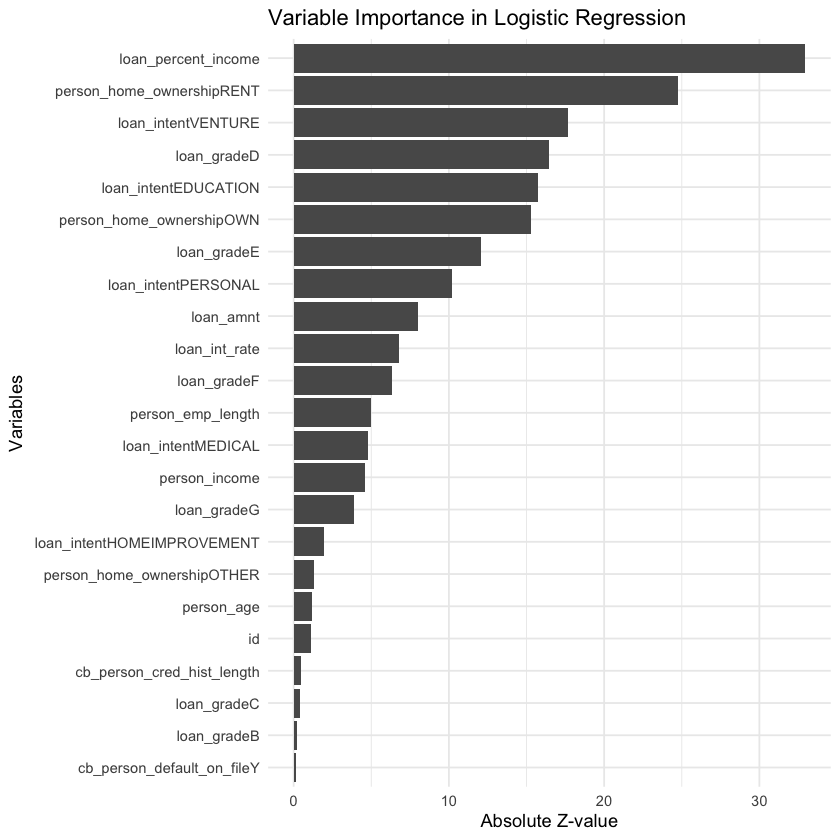

In [51]:
logistic_model <- glm(loan_status ~ ., data = train_set, family = "binomial")

var_importance <- abs(summary(logistic_model)$coefficients[,3])[-1] 
var_names <- names(var_importance)
importance_df <- data.frame(Variable = var_names, Importance = var_importance)
importance_df <- importance_df[order(-importance_df$Importance),]

# Plot variable importance
ggplot(importance_df, aes(x = reorder(Variable, Importance), y = Importance)) +
    geom_bar(stat = "identity") +
    coord_flip() +
    theme_minimal() +
    labs(title = "Variable Importance in Logistic Regression",
         x = "Variables",
         y = "Absolute Z-value")

In [44]:
# Original Model
original_model <- glm(loan_status ~ ., data = train_data, family = "binomial")

# Remove loan_int_rate
reduced_model <- glm(loan_status ~ . - loan_int_rate, data = train_data, family = "binomial")

# Compare two models
anova(reduced_model, original_model, test = "Chisq")

# Check VIF values
vif(reduced_model)

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,58622,27969.07,NA,NA,NA
2,58621,27906.95,1,62.11909,3.233015e-15


,GVIF,Df,GVIF^(1/(2*Df))
id,1.000633,1,1.000316
person_age,4.358084,1,2.087602
person_income,4.180136,1,2.044538
person_home_ownership,1.187336,3,1.029032
person_emp_length,1.091410,1,1.044706
loan_intent,1.109148,5,1.010413
loan_grade,1.827498,6,1.051529
loan_amnt,6.662219,1,2.581127
loan_percent_income,5.665481,1,2.380227
cb_person_default_on_file,1.532157,1,1.237803


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Model Performance Comparison:"
     Metric Original Reduced
1  Accuracy    0.909   0.909
2 Precision    0.804   0.806
3    Recall    0.531   0.530
4  F1 Score    0.640   0.640
5       AUC    0.904   0.902


ERROR: Error in grid.arrange(plot_conf_matrix(original_metrics$conf_matrix, "Original Model\nConfusion Matrix"), : could not find function "grid.arrange"


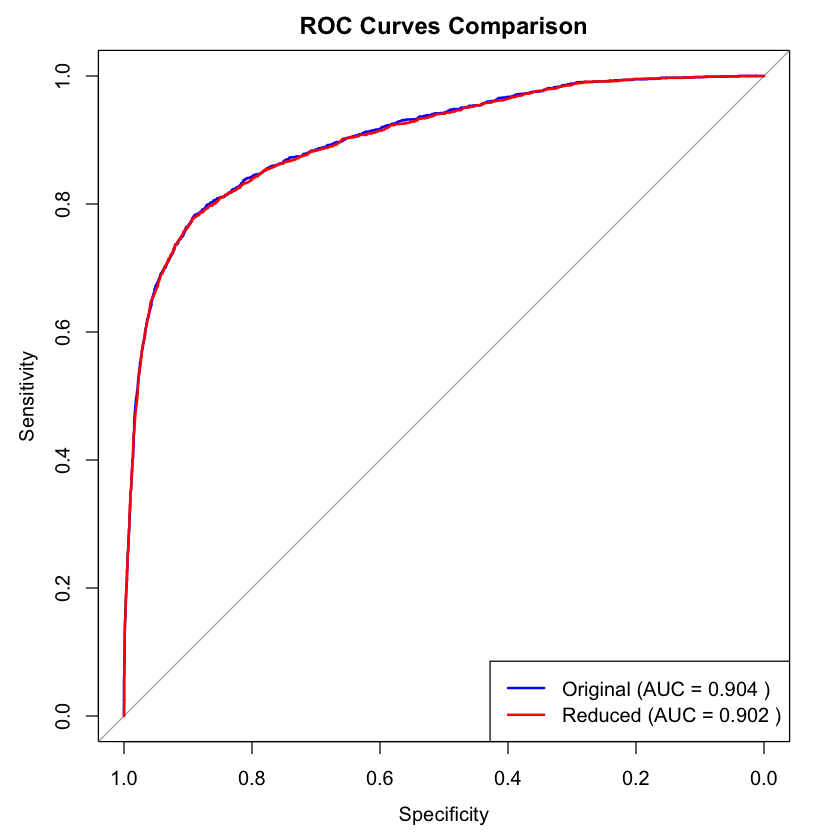

In [45]:
# Set seed for reproducibility
set.seed(123)

# Split data into training and validation sets
train_index <- sample(1:nrow(train_data), 0.8 * nrow(train_data))
train_set <- train_data[train_index, ]
val_set <- train_data[-train_index, ]

# Function to calculate performance metrics
calculate_metrics <- function(model, test_data, model_name) {
    # Make predictions
    predictions <- predict(model, newdata = test_data, type = "response")
    pred_class <- ifelse(predictions > 0.5, 1, 0)
    
    # Calculate confusion matrix
    conf_matrix <- table(Predicted = pred_class, Actual = test_data$loan_status)
    
    # Calculate metrics
    accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
    precision <- conf_matrix[2,2] / sum(conf_matrix[2,])
    recall <- conf_matrix[2,2] / sum(conf_matrix[,2])
    f1 <- 2 * (precision * recall) / (precision + recall)
    
    # Calculate ROC and AUC
    roc_obj <- roc(test_data$loan_status, predictions)
    auc_value <- auc(roc_obj)
    
    return(list(
        model_name = model_name,
        accuracy = accuracy,
        precision = precision,
        recall = recall,
        f1 = f1,
        auc = auc_value,
        conf_matrix = conf_matrix,
        roc = roc_obj
    ))
}

# Train original model
original_model <- glm(loan_status ~ ., data = train_set, family = "binomial")

# Train reduced model (without loan_int_rate)
reduced_model <- glm(loan_status ~ . - loan_int_rate, data = train_set, family = "binomial")

# Calculate metrics for both models
original_metrics <- calculate_metrics(original_model, val_set, "Original Model")
reduced_metrics <- calculate_metrics(reduced_model, val_set, "Reduced Model")

# Create comparison dataframe
metrics_comparison <- data.frame(
    Metric = c("Accuracy", "Precision", "Recall", "F1 Score", "AUC"),
    Original = c(
        original_metrics$accuracy,
        original_metrics$precision,
        original_metrics$recall,
        original_metrics$f1,
        original_metrics$auc
    ),
    Reduced = c(
        reduced_metrics$accuracy,
        reduced_metrics$precision,
        reduced_metrics$recall,
        reduced_metrics$f1,
        reduced_metrics$auc
    )
)

# Round all numeric columns to 3 decimal places
metrics_comparison[,2:3] <- round(metrics_comparison[,2:3], 3)

# Print comparison table
print("Model Performance Comparison:")
print(metrics_comparison)

# Plot ROC curves
plot(original_metrics$roc, col = "blue", main = "ROC Curves Comparison")
lines(reduced_metrics$roc, col = "red")
legend("bottomright", 
       legend = c(paste("Original (AUC =", round(original_metrics$auc, 3), ")"),
                 paste("Reduced (AUC =", round(reduced_metrics$auc, 3), ")")),
       col = c("blue", "red"),
       lwd = 2)

# Visualize confusion matrices
par(mfrow=c(1,2))

# Original model confusion matrix
plot_conf_matrix <- function(conf_matrix, title) {
    conf_matrix_df <- as.data.frame(as.table(conf_matrix))
    ggplot(conf_matrix_df, aes(x = Predicted, y = Actual, fill = Freq)) +
        geom_tile() +
        geom_text(aes(label = Freq), vjust = 1) +
        scale_fill_gradient(low = "white", high = "blue") +
        theme_minimal() +
        labs(title = title)
}

# Plot confusion matrices side by side using gridExtra
grid.arrange(
    plot_conf_matrix(original_metrics$conf_matrix, "Original Model\nConfusion Matrix"),
    plot_conf_matrix(reduced_metrics$conf_matrix, "Reduced Model\nConfusion Matrix"),
    ncol = 2
)

# Print VIF values for both models
cat("\nOriginal Model VIF values:\n")
print(vif(original_model))

cat("\nReduced Model VIF values:\n")
print(vif(reduced_model))